In [1]:
# Import Libraries
# =========================================================

## BUILT-IN IMPORTS
import warnings
from itertools import combinations
from collections import Counter, defaultdict

## DATA MANIPULATION IMPORTS
import numpy as np
import pandas as pd

## VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

## SKLEARN
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

## XGBOOST
import xgboost as xgb
from xgboost import cv
from xgboost import XGBClassifier

## SHAP
#import shap

## GLOBAL SETTINGS
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None 
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use("ggplot")
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option("display.max_rows", 500)
plt.rcParams["savefig.bbox"] = "tight"

In [2]:
def missing_summary(df):
    has_non = 0
    for column in df.columns:
        total_values = len(df)
        missing_values = df[column].isnull().sum()
        percentage = ((missing_values/total_values)*100).round(2)
        if missing_values > 0:
            print('df["{}"] - Total values: {}, Missing values: {} ({}%)'.format(column, total_values, missing_values, percentage,))
        else:
            has_non += 1
    if has_non == len(df.columns):
        print("Provided dataframe does not have any missing values.")
        
#############################################################
## my 5 minutes of extreme sillyness
def print_formatted_word(word):
    total_length = len("####################  SCORES & EVALUATIONS  #############################")
    word_length = len(word)
    num_of_hashes_before = len("####################  ")
    num_of_hashes_after = total_length - (num_of_hashes_before + word_length)
    print("#" * num_of_hashes_before + " " + word + " " + "#" * num_of_hashes_after)

#############################################################
def get_other_active_products(row, products, TARGET):
    product_string_index = row.index.get_loc(TARGET)
    product_string_activation_index = row[product_string_index].rfind("01") if "01" in row[product_string_index] else None

    #row[product_string_index] = row[product_string_index].split("01")[0]

    other_active_products = []
    if product_string_activation_index is not None:
        for i, column in enumerate(row.index):
            if i != product_string_index and column in products:
                if row[column][product_string_activation_index] == "1":
                    other_active_products.append(column)
    else:
        other_active_products.append(None)
    
    return other_active_products

In [3]:
#df = pd.read_csv("../data/Bobs_df_semi_clean.csv")
df = pd.read_csv("../data/Bobs_df_delivery.csv")
#df.drop("Unnamed: 0", axis = 1, inplace = True)
df["pk_partition"] = pd.to_datetime(df["pk_partition"])
df["entry_date"] = pd.to_datetime(df["entry_date"])
df["pk_cid"] = df["pk_cid"].astype(str)

In [9]:
df.head(3)

,pk_cid,pk_partition,country_id,region_code,gender,age,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount,entry_date,entry_channel,active_customer,Total_products,year_partition,month_partition,year_month_partition,quarter_entry,year_month_entry,age_corrected,salary_LN
0,1375586,2018-01-28,ES,Malaga,H,35,"87,218.1000",0,0,0,0,0,0,0,0,0,0,0,0,1,2018-01-12,others,1,1,2018,1,2018-01,2018-Q1,2018-01,36,11.3762
1,1050611,2018-01-28,ES,Ciudad Real,V,23,"35,548.7400",0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,KHE,0,1,2018,1,2018-01,2015-Q3,2015-08,24,10.4787
2,1050612,2018-01-28,ES,Ciudad Real,V,23,"122,179.1100",0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,KHE,0,1,2018,1,2018-01,2015-Q3,2015-08,23,11.7133


In [69]:
missing_summary(df)

df["gender"] - Total values: 5962924, Missing values: 25 (0.0%)


In [8]:
df.rename(columns = {
    "payroll": "payroll_product", 
    "payroll_account": "payroll_bonus",
    "active_customer": "active_on_app"}, inplace = True)

In [15]:
product_revenue_map = {"short_term_deposit": 60, "loans": 40, "mortgage": 40, "funds": 60, "securities": 60, "long_term_deposit": 60, "credit_card": 40, "pension_plan": 60, "payroll_product": 10, "emc_account": 10, "debit_card": 40, "em_acount": 10}

products = list(product_revenue_map.keys())

In [12]:
def fillna_ffill(df, feature):
    missing_data = df[df[feature].isnull()]['pk_cid'].unique().tolist()
    df_missing = df[df['pk_cid'].isin(missing_data)][['pk_cid', feature]].sort_values(by='pk_cid')
    df_missing[feature] = df_missing[feature].fillna(method='ffill')
    df.loc[df_missing.index, feature] = df_missing[feature]
    return df
#fillna_ffill(df)

In [13]:
## removing deceased customers and respective feature
#df = df[df["deceased"] == 0]
#df.drop("deceased", axis = 1, inplace = True)

## we will focus on customers registed and resident in Spain (ES)
#df = df[df["country_id"] == "ES"]
#df.drop("country_id", axis = 1, inplace = True)

## ultimately we will only be looking at users who have been active in the last 3 months, so we can drop all users who are users for less than 3 months
#df = df[df["entry_date"] <= "2019-03-01"]

## dropping entry date as we're only interested in users who have been active recently and we only have data for the past 17 months. What happened before we do not know.
#df.drop("entry_date", axis = 1, inplace = True)

## also dropping "segment" and "gender" features for trust and ethics reasons
#df.drop(["Male", "segment"], axis = 1, inplace = True)

## and dropping "salary" features, as we have too many missing values and values do not seem realistic (way above any reasonable salary)
#df.drop(["salary", "salary_LN"], axis = 1, inplace = True)

## finally dropping "active_customer" feature as we're only looking into users with active products. We assume that all users with active prodcuts are active customers.
#df.drop("active_customer", axis = 1, inplace = True)

df.shape

(5962924, 31)

In [9]:
## creating revenue features
#df_product = df[products]
#revenues = np.array([product_revenue_map[f] for f in products])
#df["total_revenue"] = (df_product * revenues).sum(axis = 1)
#df_user_revenue = df.groupby("pk_cid")["total_revenue"].sum().reset_index()
#df = pd.merge(df, df_user_revenue, on = "pk_cid", how = "left")

#df.rename(columns = {"total_revenue_x": "revenue_month", "total_revenue_y": "revenue_total"}, inplace = True)

In [10]:
## adding revenue class feature
#revenue_classes_dict = {
#    "None": (-1, 0),
#    "Micro": (1, 50),
#    "Low": (51, 170),    
#    "mid": (171, 849),
#    "upper": (850, 1200),
#    "high": (1201, 10000)}

#df["revenue_class"] = df["revenue_total"].apply(
#    lambda x: next((cat for cat, range in revenue_classes_dict.items() if range[0] <= x #<= range[1])))

In [11]:
# removing customers with zero revenue as we cannot make conclusions about purchase and tenure behavior
#print(df.shape)
#df = df[df["revenue_class"] != "None"]

In [16]:
for feature in products:
    df[feature] = df[feature].astype(int)
df["payroll_bonus"] = df["payroll_bonus"].astype(int)
df["active_on_app"] = df["active_on_app"].astype(int)

In [17]:
df["pk_cid"].nunique()

456373

In [22]:
def stringify_df(data):

    data = data.copy(deep = True)
    to_stringify = ["em_acount", "emc_account", "short_term_deposit", "long_term_deposit", 
                    "loans", "mortgage", "funds", "securities", "debit_card", "credit_card", "pension_plan", 
                    "payroll_product", "payroll_bonus", "active_on_app"]
 
    string_DF = pd.DataFrame(index = data["pk_cid"].unique())

    for feature in to_stringify:
        pivot_table = data.pivot_table(index = "pk_cid", columns = "pk_partition", values = feature, aggfunc = "first")
        temp_table = pivot_table.applymap(lambda x: str(int(x)) if pd.notnull(x) else "x")
        temp_table[feature] = temp_table.apply(lambda row: "".join(row.values), axis = 1)
        string_DF = pd.concat([string_DF, temp_table[feature]], axis = 1)
        
    return string_DF

#STRING_DF = stringify_df(df)
#STRING_DF

,em_acount,emc_account,short_term_deposit,long_term_deposit,loans,mortgage,funds,securities,debit_card,credit_card,pension_plan,payroll_product,payroll_bonus,active_on_app
1375586,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00001110000000001,00000000000000000,00000000000000000,00000000000000000,00000000000000000,11111110000000101
1050611,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000
1050612,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000
1050613,000xxx00000000000,000xxx00000000000,110xxx00000000000,000xxx00000000000,000xxx00000000000,000xxx00000000000,000xxx00000000000,000xxx00000000000,000xxx00000000000,000xxx00000000000,000xxx00000000000,000xxx00000000000,000xxx00000000000,000xxx00000000000
1050614,11111111111111111,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,00000000000000000,11111111111111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185013,xxxxxxxxxxxxxxxx1,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx1
1168909,xxxxxxxxxxxxxxxx1,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx1
1173729,xxxxxxxxxxxxxxxx1,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx1
1164094,xxxxxxxxxxxxxxxx1,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx0,xxxxxxxxxxxxxxxx1


In [23]:
activity_products = ["debit_card", "credit_card", "payroll_product", "pension_plan"]
plan_products = ["emc_account", "em_acount", "short_term_deposit", "long_term_deposit", "securities", "funds", "mortgage", "loans"]
activity_indicators = ["active_on_app", "payroll_bonus"]
all_prod_features = activity_products + plan_products + activity_indicators

In [24]:
def remove_fully_inactives(data):
    check_me = data.groupby("pk_cid")[all_prod_features].sum()
    check_me = check_me[check_me.sum(axis = 1) > 1].index
    data_ = df[df["pk_cid"].isin(check_me)]

    return data_


def expand_features(data):

    data = data.copy(deep = True)
    return_DF = pd.DataFrame(index = data["pk_cid"].unique())
    #return_DF = pd.concat([return_DF, data.groupby("pk_cid")["age"].max()], axis = 1)

    for feature in all_prod_features: 

        exp_features = pd.DataFrame(index = data["pk_cid"].unique())
        pivot_table = data.pivot_table(index = "pk_cid", columns = "pk_partition", values = feature, aggfunc = "first")
        
        exp_features = pivot_table.applymap(lambda x: str(int(x)) if pd.notnull(x) else "x")

        exp_features[feature] = exp_features.apply(lambda row: "".join(row.values), axis = 1)
        exp_features = exp_features[[feature]] 
        exp_features = exp_features[feature].str.split("", expand = True).iloc[:, 1:-1]
        exp_features = exp_features.add_prefix(feature)
        exp_features.replace("x", -1, inplace = True)

        return_DF = pd.concat([return_DF, exp_features], axis = 1)
        return_DF = return_DF.astype(int)
    
    return return_DF

In [20]:
TARGET = "emc_account"
df[TARGET].value_counts()

0    5635963
1     326961
Name: emc_account, dtype: int64

In [25]:
exp_DF = expand_features(remove_fully_inactives(df))

EXP_MODEL_DF = exp_DF.copy(deep = True)
EXP_MODEL_DF = EXP_MODEL_DF.astype(int)

EXP_MODEL_DF.rename(columns = {f"{TARGET}17": "TARGET"}, inplace = True)
EXP_MODEL_DF["TARGET"] = EXP_MODEL_DF["TARGET"].apply(lambda x: 1 if x == 1 else 0)

EXP_MODEL_DF = EXP_MODEL_DF.drop(EXP_MODEL_DF.filter(like = TARGET).columns, axis = 1)
EXP_MODEL_DF = EXP_MODEL_DF.drop(EXP_MODEL_DF.filter(like = "17").columns, axis = 1)
EXP_MODEL_DF["TARGET"].value_counts()

0    327566
1     24751
Name: TARGET, dtype: int64

In [39]:
AGG_DF = df.copy(deep = True)

AGG_DF = remove_fully_inactives(AGG_DF)

target_cids = AGG_DF[(AGG_DF["pk_partition"] == "2019-05-28") & (AGG_DF[TARGET] == 1)]["pk_cid"].to_list()

AGG_DF = AGG_DF[(AGG_DF["pk_partition"] != "2019-05-28")]

AGG_DF = AGG_DF.groupby("pk_cid").agg({
        **{feature: "sum" for feature in plan_products},
        **{feature: "mean" for feature in activity_products},
        **{feature: "mean" for feature in activity_indicators},
        TARGET: "size"})

AGG_DF.rename(columns = {TARGET: "total_records"}, inplace = True)

AGG_DF["TARGET"] = (AGG_DF.index.isin(target_cids)).astype(int)
AGG_DF["TARGET"].value_counts()

0    326120
1     24686
Name: TARGET, dtype: int64

In [685]:
#stringed_DF["other_active_products"] = stringed_DF["other_active_products"].astype(str)
#stringed_DF["other_active_products"] = stringed_DF["other_active_products"].str.strip('[]').str.replace("'", "").str.replace(" ", "")

#stringed_DF_ = stringed_DF["other_active_products"].str.split(",", expand = True)

#stringed_DF_.reset_index(inplace = True)

#cooc_pre = stringed_DF_.melt(id_vars = "index")
#cooc_pre["value"].fillna("Unknown", inplace = True)
#cooc_pre.rename(columns = {"index" :"pk_cid"}, inplace = True)

#cooc_pre = cooc_pre.pivot_table(index = "pk_cid", columns = "value", aggfunc = len, fill_value = 0)
#new_columns = [tupple[1] for tupple in list(cooc_pre.columns)]
#cooc_pre.columns = new_columns
#cooc_pre.reset_index(inplace = True)
#cooc_pre.head()

#cooc_pre.drop(["", "None", "Unknown"], axis = 1, inplace = True)
#cooc_pre.set_index("pk_cid", inplace = True)

In [567]:
# retention per product (total number of active months)
# retention / activity time per product (total number of active months / total number of months)
# recency per product (months past since latest activation)

#stringed_DF["TARGET"] = stringed_DF[TARGET].apply(lambda x: 1 if "01" in x else 0)
#stringed_DF["active_months"] = stringed_DF["loans"].apply(lambda s: len(s))

#for product in [p for p in products if p != TARGET]:

#    tenure_ = stringed_DF[product].apply(
#        lambda s: sum([int(i) for i in s]))
#    stringed_DF[product + "_tenure_rate"] = tenure_ / len(df[product][0])
    
#    stringed_DF[product + "_last_act"] = stringed_DF[product].apply(
#       lambda s: 
#            -1 if "1" in s and s.rfind("01") == -1 
#            else len(s) - s.rfind("01") - 2 if s.rfind("01") != -1 
#            else 999999)

#stringed_DF.drop(products, axis = 1, inplace = True)
#stringed_DF.drop("other_active_products", axis = 1, inplace = True)

In [43]:
#corr_matrix = final_DF.corr().abs()
#upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
#to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
#print(to_drop)
#final_DF = final_DF.drop(to_drop, axis = 1)

In [49]:
#MODEL_DF.corr().style.background_gradient(axis = None)

In [26]:
def prep_model_dfs(data):
    X = data.drop(["TARGET"], axis = 1)
    y = data["TARGET"]

    balance = (len(data[data["TARGET"] == 1]) / len(data[data["TARGET"] == 0])) * 100

    train, test, target, target_test = train_test_split(
        X, y, test_size = 0.3)

    split_data_dict = {
        "TRAINING": [train, target],
        "TESTING": [test, target_test]}

    print("Train:", train.shape, "| Target Mean:", target.mean())
    print("Test:", test.shape, "| Target Mean:", target_test.mean())
    
    return split_data_dict, balance, X, y

In [ ]:
params_grid = { 
    "max_depth": [4, 8, 12, 16],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 500, 1000],
    "colsample_bytree": [0.3, 0.7]}

xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator = xgbr, 
                   param_grid = params_grid,
                   scoring = "recall", 
                   verbose = 1)
clf.fit(split_data_dict["TRAINING"][0], split_data_dict["TRAINING"][1])
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)

In [ ]:
split_data_dict, balance, X, y = prep_model_dfs(AGG_DF)

XGB_model = XGBClassifier(
    max_depth = 16,
    random_state = 42,
    learning_rate = 0.0001,
    n_estimators = 500,	
    colsample_bylevel = 0.5,
    verbosity = 0,
    scale_pos_weight = balance,
    n_jobs = -1)

XGB_model.fit(split_data_dict["TRAINING"][0], split_data_dict["TRAINING"][1])

In [28]:
split_data_dict, balance, X, y = prep_model_dfs(EXP_MODEL_DF)

XGB_model = XGBClassifier(
    max_depth = 16,
    random_state = 42,
    learning_rate = 0.00001,
    n_estimators = 500,	
    colsample_bylevel = 0.5,
    verbosity = 0,
    scale_pos_weight = balance,
    n_jobs = -1)

XGB_model.fit(split_data_dict["TRAINING"][0], split_data_dict["TRAINING"][1])

Train: (246621, 208) | Target Mean: 0.0701967796740748
Test: (105696, 208) | Target Mean: 0.07038109294580684


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1e-05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [29]:
#print_formatted_word("SCORES & EVALUATIONS")
print_formatted_word(TARGET)
print("\n______________________ SCORES & EVALUATIONS _______________________________\n")

for data in split_data_dict.items():

    pred = XGB_model.predict(data[1][0])
    confusion_matrix = metrics.confusion_matrix(data[1][1], pred)
    tn, fp, fn, tp = confusion_matrix.ravel()
    Accuracy = metrics.accuracy_score(data[1][1], pred)
    Precision = metrics.precision_score(data[1][1], pred)
    Recall = metrics.recall_score(data[1][1], pred)
    F_1_Score = metrics.f1_score(data[1][1], pred)

    probs = XGB_model.predict_proba(data[1][0])[:, 1]
    probs_mean = round(probs.mean()* 100, 2) 
    auc_score = roc_auc_score(data[1][1], probs)
    fpr, tpr, thresholds = roc_curve(data[1][1], probs)

    PPV, NPV = ((tp / (tp + fp)) * 100), ((tn / (fn + tn)) * 100)
    
    
    print_formatted_word(data[0])
    print(f"Accuracy: {round(Accuracy, 5)} | Precision: {round(Precision, 5)} | Recall: {round(Recall, 5)} | F1_Score: {round(F_1_Score, 5)}")
    print(f"TN = {tn} | FN = {fn} | TP = {tp} | FP = {fp}")
    print(f"Positive prediction value: {round(PPV, 2)}% | Negative prediction value: {round(NPV, 2)}%\n")

###################### emc_account ########################################

______________________ SCORES & EVALUATIONS _______________________________

###################### TRAINING ###########################################
Accuracy: 0.89975 | Precision: 0.38492 | Recall: 0.71592 | F1_Score: 0.50066
TN = 209504 | FN = 4918 | TP = 12394 | FP = 19805
Positive prediction value: 38.49% | Negative prediction value: 97.71%

###################### TESTING ############################################
Accuracy: 0.89056 | Precision: 0.35061 | Recall: 0.65116 | F1_Score: 0.4558
TN = 89285 | FN = 2595 | TP = 4844 | FP = 8972
Positive prediction value: 35.06% | Negative prediction value: 97.18%



###################### CROSS-VALIDATION ###################################
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.9098         0.0011         0.8780        0.0034
1          0.9139         0.0014         0.8867        0.0015
2          0.9152         0.0012         0.8889        0.0017
3          0.9158         0.0013         0.8902        0.0017
4          0.9163         0.0012         0.8910        0.0019


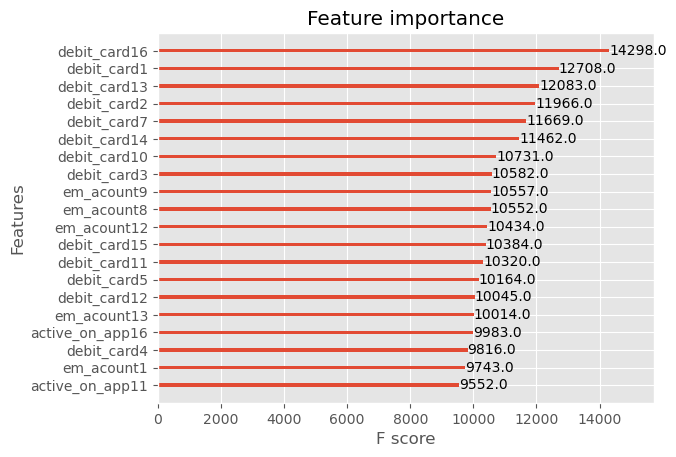

In [58]:
data_dmatrix = xgb.DMatrix(X, y)
xgb_cv = cv(
    dtrain = data_dmatrix, 
    params = XGB_model.get_params(), 
    nfold = 3,
    num_boost_round = 50, 
    early_stopping_rounds = 10, 
    metrics = "auc", 
    as_pandas = True, 
    seed = 42)

print_formatted_word("CROSS-VALIDATION")
  
print(xgb_cv.head())

xgb.plot_importance(XGB_model, max_num_features = 20)
plt.show()

In [52]:
apply_DF = EXP_MODEL_DF[EXP_MODEL_DF["TARGET"] == 0]
apply_DF.drop(["TARGET"], axis = 1, inplace = True)
probs_apply = XGB_model.predict_proba(apply_DF)
probs_apply

array([[0.50154936, 0.49845064],
       [0.5023879 , 0.4976121 ],
       [0.5023879 , 0.4976121 ],
       ...,
       [0.5020894 , 0.49791062],
       [0.5020894 , 0.49791062],
       [0.5020894 , 0.49791062]], dtype=float32)

In [53]:
Test_OUT = apply_DF.copy(deep = True)
Test_OUT["probs"] = probs_apply[:, 1]

In [54]:
Test_OUT.sort_values(by = "probs", ascending = False).head(10)

,debit_card1,debit_card2,debit_card3,debit_card4,debit_card5,debit_card6,debit_card7,debit_card8,debit_card9,debit_card10,debit_card11,debit_card12,debit_card13,debit_card14,debit_card15,debit_card16,credit_card1,credit_card2,credit_card3,credit_card4,credit_card5,credit_card6,credit_card7,credit_card8,credit_card9,credit_card10,credit_card11,credit_card12,credit_card13,credit_card14,credit_card15,credit_card16,payroll_product1,payroll_product2,payroll_product3,payroll_product4,payroll_product5,payroll_product6,payroll_product7,payroll_product8,payroll_product9,payroll_product10,payroll_product11,payroll_product12,payroll_product13,payroll_product14,payroll_product15,payroll_product16,pension_plan1,pension_plan2,pension_plan3,pension_plan4,pension_plan5,pension_plan6,pension_plan7,pension_plan8,pension_plan9,pension_plan10,pension_plan11,pension_plan12,pension_plan13,pension_plan14,pension_plan15,pension_plan16,em_account_p1,em_account_p2,em_account_p3,em_account_p4,em_account_p5,em_account_p6,em_account_p7,em_account_p8,em_account_p9,em_account_p10,em_account_p11,em_account_p12,em_account_p13,em_account_p14,em_account_p15,em_account_p16,em_acount1,em_acount2,em_acount3,em_acount4,em_acount5,em_acount6,em_acount7,em_acount8,em_acount9,em_acount10,em_acount11,em_acount12,em_acount13,em_acount14,em_acount15,em_acount16,short_term_deposit1,short_term_deposit2,short_term_deposit3,short_term_deposit4,short_term_deposit5,short_term_deposit6,short_term_deposit7,short_term_deposit8,short_term_deposit9,short_term_deposit10,short_term_deposit11,short_term_deposit12,short_term_deposit13,short_term_deposit14,short_term_deposit15,short_term_deposit16,long_term_deposit1,long_term_deposit2,long_term_deposit3,long_term_deposit4,long_term_deposit5,long_term_deposit6,long_term_deposit7,long_term_deposit8,long_term_deposit9,long_term_deposit10,long_term_deposit11,long_term_deposit12,long_term_deposit13,long_term_deposit14,long_term_deposit15,long_term_deposit16,securities1,securities2,securities3,securities4,securities5,securities6,securities7,securities8,securities9,securities10,securities11,securities12,securities13,securities14,securities15,securities16,funds1,funds2,funds3,funds4,funds5,funds6,funds7,funds8,funds9,funds10,funds11,funds12,funds13,funds14,funds15,funds16,mortgage1,mortgage2,mortgage3,mortgage4,mortgage5,mortgage6,mortgage7,mortgage8,mortgage9,mortgage10,mortgage11,mortgage12,mortgage13,mortgage14,mortgage15,mortgage16,loans1,loans2,loans3,loans4,loans5,loans6,loans7,loans8,loans9,loans10,loans11,loans12,loans13,loans14,loans15,loans16,active_on_app1,active_on_app2,active_on_app3,active_on_app4,active_on_app5,active_on_app6,active_on_app7,active_on_app8,active_on_app9,active_on_app10,active_on_app11,active_on_app12,active_on_app13,active_on_app14,active_on_app15,active_on_app16,payroll_bonus1,payroll_bonus2,payroll_bonus3,payroll_bonus4,payroll_bonus5,payroll_bonus6,payroll_bonus7,payroll_bonus8,payroll_bonus9,payroll_bonus10,payroll_bonus11,payroll_bonus12,payroll_bonus13,payroll_bonus14,payroll_bonus15,payroll_bonus16,probs
1261044,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5024
1236807,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [57]:
Test_OUT["probs"].describe()

count   327,460.0000
mean          0.4993
std           0.0014
min           0.4975
25%           0.4976
50%           0.4979
75%           0.4994
max           0.5024
Name: probs, dtype: float64

In [709]:
pd.Series(probs_apply[:, 1]).sort_values(ascending = True).value_counts().head()

0.4093    440206
dtype: int64

In [710]:
LL = pd.Series(probs_apply[:, 1]).sort_values(ascending = False)

In [711]:
LL[LL > 0.5].count()

0

In [712]:
LL.describe()

count   440,206.0000
mean          0.4076
std           0.0017
min           0.4093
25%           0.4093
50%           0.4093
75%           0.4093
max           0.4093
dtype: float64

In [464]:
apply_DF

,age,active_months,short_term_deposit_tenure_rate,loans_tenure_rate,mortgage_tenure_rate,funds_tenure_rate,securities_tenure_rate,long_term_deposit_tenure_rate,credit_card_tenure_rate,pension_plan_tenure_rate,emc_account_tenure_rate,debit_card_tenure_rate,em_account_p_tenure_rate,em_acount_tenure_rate,em_acount_last_act,credit_card,debit_card,em_account_p,em_acount,emc_account,funds,loans,long_term_deposit,mortgage,securities,short_term_deposit
1375586,36,17,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,17.0000,-1,0,0,0,0,0,0,0,0,0,0,0
1050611,24,17,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,17.0000,-1,0,0,0,0,0,0,0,0,0,0,0
1050612,23,17,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,17.0000,-1,0,0,0,0,0,0,0,0,0,0,0
1050613,23,14,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,999999,0,0,0,0,0,0,0,0,0,0,0
1050614,24,17,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,17.0000,-1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017056,34,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,1.0000,0,0,0,0,0,0,0,0,0,0,0,0
1014969,46,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,-1,0,0,0,0,0,0,0,0,0,0,0
1082677,28,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,2.0000,1,0,0,0,0,0,0,0,0,0,0,0
1035063,33,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,2.0000,1,0,0,0,0,0,0,0,0,0,0,0
